In [ ]:
!nvidia-smi

Sat Sep 25 10:01:55 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P8    34W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import cv2
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torch.nn as nn
from torchvision import transforms
import torch.nn.functional as F
from torchvision.utils import save_image

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
device

device(type='cuda')

## Depth Wise Seprable Convolution

This convolution originated from the idea that depth and spatial dimension of a filter can be separated- thus the name separable. You can separate the height and width dimension of these filters. Gx filter (see fig 3) can be viewed as matrix product of [1 2 1] transpose with [-1 0 1].

that the filter had disguised itself. It shows it had 9 parameters but it has actually 6. This has been possible because of separation of its height and width dimensions. The same idea applied to separate depth dimension from horizontal (width*height) gives us depth-wise separable convolution whare we perform depth-wise convolution and after that we use a 1*1 filter to cover the depth dimension.

### Torch Implementation Related Documen
`torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros', device=None, dtype=None)`

Parameters:
```
stride controls the stride for the cross-correlation, a single number or a tuple.

padding controls the amount of padding applied to the input. It can be either a string {‘valid’, ‘same’} or a tuple of ints giving the amount of implicit padding applied on both sides.

dilation controls the spacing between the kernel points; also known as the à trous algorithm. It is harder to describe, but this link has a nice visualization of what dilation does.

groups controls the connections between inputs and outputs. in_channels and out_channels must both be divisible by groups.
```

In [ ]:
class depthwise_separable_conv(nn.Module):
    def __init__(self, nin, kernels_per_layer, nout):
        super(depthwise_separable_conv, self).__init__()
        self.depthwise = nn.Conv2d(nin, nin * kernels_per_layer, kernel_size=5, padding=2, groups=nin)
        self.pointwise = nn.Conv2d(nin * kernels_per_layer, nout, kernel_size=1)

    def forward(self, x):
        out = self.depthwise(x)
        out = self.pointwise(out)
        return out

## Swish Activation Function

Swish is a smooth, non-monotonic function that consistently matches or outperforms ReLU on deep networks applied to a variety of challenging domains such as Image classification and Machine translation. It is unbounded above and bounded below & it is the non-monotonic attribute that actually creates the difference. With self-gating, it requires just a scalar input whereas in multi-gating scenario, it would require multiple two-scalar input.

In [ ]:
def swish(x):
    return x * torch.sigmoid(x)

## Squeeze and Excitation Networks

For more information see <a href='https://arxiv.org/pdf/1709.01507.pdf'>this paper.</a>

Squeeze-and-Excitation Networks (SENets) introduce a building block for CNNs that improves channel interdependencies at almost no computational cost.

The transformation simply corresponds with the operation that the network where you are going to implement the SE block would perform in its natural scheme. For instance, if you are in a block within a ResNet, the Ftr term will correspond with the process of the entire residual block (convolution, batch normalization, ReLU…). 

The squeezing step is probably the most simply one. It basically performs a average pooling at each channel to create a 1x1 squeezed representation of the volume U.

The authors introduce a new parameter called the reduction ratio r, to introduce a first fully connected (FC) layer with a ReLU activation, before the gating network with the sigmoid activation.

The reason to do this is to introduce a bottleneck that allows us to reduce the dimensionality at the same time that introduce new non-linearities.

Furthermore, we can have better control on the model complexity and aid the generalization property of the network.

Having two FC layers will result on having 2 matrices of weights that will be learned by the network during the training in an end-to-end fashion (all of them are backpropagated together with the convolutional kernels).

The last step, scaling, is indeed a re-scaling operation. We are going to give the squeezed vector its original shape, keeping the information obtained during the excitation step.

Mathematically, the scaling is achieved by simple scalar product of each channel on the input volume with the corresponding channel on the activated 1x1 squeezed vector.

In [ ]:
class ChannelSELayer(nn.Module):
    def __init__(self, num_channels, reduction_ratio=2):
        super(ChannelSELayer, self).__init__()
        num_channels_reduced = num_channels // reduction_ratio
        self.reduction_ratio = reduction_ratio
        self.fc1 = nn.Linear(num_channels, num_channels_reduced, bias=True)
        self.fc2 = nn.Linear(num_channels_reduced, num_channels, bias=True)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, input_tensor):
        batch_size, num_channels, H, W = input_tensor.size()
        squeeze_tensor = input_tensor.view(batch_size, num_channels, -1).mean(dim=2)

        fc_out_1 = self.relu(self.fc1(squeeze_tensor))
        fc_out_2 = self.sigmoid(self.fc2(fc_out_1))

        a, b = squeeze_tensor.size()
        output_tensor = torch.mul(input_tensor, fc_out_2.view(a, b, 1, 1))
        return output_tensor

In [ ]:
class dec_res(nn.Module):
  def __init__(self,in_channel):
    super(dec_res,self).__init__()
    self.bn1 = nn.BatchNorm2d(in_channel)
    self.c1 = nn.Conv2d(in_channels=in_channel,out_channels=2*in_channel,kernel_size=1,stride=1,padding=0)
    self.bn2 = nn.BatchNorm2d(2*in_channel)
    self.dc1 = depthwise_separable_conv(nin=2*in_channel,kernels_per_layer=3,nout=2*in_channel)
    self.bn3 = nn.BatchNorm2d(2*in_channel)
    self.c2 = nn.Conv2d(in_channels=2*in_channel,out_channels=in_channel,kernel_size=1,stride=1,padding=0)
    self.bn4 = nn.BatchNorm2d(in_channel)
    self.SE = ChannelSELayer(in_channel)
  def forward(self,x1):
    x = self.c1(self.bn1(x1))
    x = swish(self.bn2(x))
    x = self.dc1(x)
    x = swish(self.bn3(x))
    x = self.bn4(self.c2(x))
    x = self.SE(x)
    return x+x1

In [ ]:
class enc_res(nn.Module):
  def __init__(self,in_channel):
    super(enc_res,self).__init__()
    self.bn1 = nn.BatchNorm2d(in_channel)
    self.c1 = nn.Conv2d(in_channels=in_channel,out_channels=2*in_channel,kernel_size=3,stride=1,padding=1)
    self.bn2 = nn.BatchNorm2d(2*in_channel)
    self.c2 = nn.Conv2d(in_channels=2*in_channel,out_channels=in_channel,kernel_size=3,stride=1,padding=1)
    self.bn3 = nn.BatchNorm2d(in_channel)
    self.SE = ChannelSELayer(in_channel)
  def forward(self,x1):
    x = self.c1(swish(self.bn1(x1)))
    x = self.c2(swish(self.bn2(x)))
    x = self.SE(x)
    return x+x1

In [ ]:
class NVAE(nn.Module):
  def __init__(self,start_channel,original_dim):
    super(NVAE,self).__init__()
    self.original_dim = original_dim
    self.conv1 = nn.Conv2d(in_channels=start_channel,out_channels=8,kernel_size=3,stride=1,padding=1)
    self.encblock1 = enc_res(8)
    self.dsconv1 = nn.Conv2d(in_channels=8,out_channels=8,kernel_size=2,stride=2,padding=0)
    self.encblock2 = enc_res(8)
    self.dsconv2 = nn.Conv2d(in_channels=8,out_channels=8,kernel_size=2,stride=2,padding=0)

    self.qmu1 = nn.Linear(original_dim*original_dim*2,original_dim*original_dim*2)
    self.qvar1 = nn.Linear(original_dim*original_dim*2,original_dim*original_dim*2)
    
    self.qmu0 = nn.Linear(original_dim*original_dim//2,original_dim*original_dim//2)
    self.qvar0 = nn.Linear(original_dim*original_dim//2,original_dim*original_dim//2)

    self.pmu1 = nn.Linear(original_dim*original_dim*2,original_dim*original_dim*2)
    self.pvar1 = nn.Linear(original_dim*original_dim*2,original_dim*original_dim*2)

    self.decblock1 = dec_res(8)
    self.usconv1 = nn.ConvTranspose2d(in_channels=8,out_channels=8,kernel_size=2,stride=2,padding=0)
    self.decblock2 = dec_res(16)
    self.usconv2 = nn.ConvTranspose2d(in_channels=16,out_channels=16,kernel_size=2,stride=2,padding=0)
    self.decblock3 = dec_res(16)
    self.finconv = nn.Conv2d(in_channels=16,out_channels=start_channel,kernel_size=3,stride=1,padding=1)
  
  def forward(self,x):
    z1 = self.dsconv1(self.encblock1(self.conv1(x)))
    z0 = self.dsconv2(self.encblock2(z1))

    qmu0 = self.qmu0(z0.reshape(z0.shape[0],self.original_dim*self.original_dim//2))
    qvar0 = self.qvar0(z0.reshape(z0.shape[0],self.original_dim*self.original_dim//2))

    qmu1 = self.qmu1(z1.reshape(z1.shape[0],self.original_dim*self.original_dim*2))
    qvar1 = self.qvar1(z1.reshape(z1.shape[0],self.original_dim*self.original_dim*2))

    stdvar0 = qvar0.mul(0.5).exp_()
    stdvar1 = qvar1.mul(0.5).exp_()

    e0 = torch.randn(qmu0.shape).to(device)
    ez0 = qmu0+e0*stdvar0
    ez0 = ez0.reshape(ez0.shape[0],8,self.original_dim//4,self.original_dim//4)
    ez1 = self.usconv1(self.decblock1(ez0))

    pmu1 = self.pmu1(ez1.reshape(ez1.shape[0],self.original_dim*self.original_dim*2))
    pvar1 = self.pvar1(ez1.reshape(ez1.shape[0],self.original_dim*self.original_dim*2))

    pstdvar1 = pvar1.mul(0.5).exp_()

    e2 = torch.randn(qmu1.shape).to(device)
    ez2 = pmu1+qmu1 + e2*pstdvar1*stdvar1
    ez2 = ez2.reshape(ez2.shape[0],8,self.original_dim//2,self.original_dim//2)
    
    final = torch.cat((ez1,ez2),1)

    recons = nn.Sigmoid()(self.finconv(self.decblock3(self.usconv2(self.decblock2(final)))))

    return qmu0,qvar0,qmu1,qvar1,pmu1,pvar1,recons

  def sample(self,bs):
    e = torch.randn([bs,8,self.original_dim//4,self.original_dim//4]).to(device)
    ez1 = self.usconv1(self.decblock1(e))

    pmu1 = self.pmu1(ez1.reshape(ez1.shape[0],self.original_dim*self.original_dim*2))
    pvar1 = self.pvar1(ez1.reshape(ez1.shape[0],self.original_dim*self.original_dim*2))

    stdvar1 = pvar1.mul(0.5).exp_()

    e1 = torch.randn([ez1.shape[0],self.original_dim*self.original_dim*2]).to(device)
    e1 = pmu1 + e1*stdvar1
    e1 = e1.reshape(e1.shape[0],8,self.original_dim//2,self.original_dim//2)
    recons = nn.Sigmoid()(self.finconv(self.decblock3(self.usconv2(self.decblock2(torch.cat((ez1,e1),1))))))

    return recons

  def loss(self,x):
    qmu0,qvar0,qmu1,qvar1,pmu1,pvar1,recons = self.forward(x)
    klz0 = 0.5*torch.sum(torch.square(qmu0)+qvar0.exp()-qvar0-1)/x.shape[0]
    klz1 = 0.5*torch.sum(torch.square(qmu1)/pvar1.exp()+qvar1.exp()-qvar1-1)
    reconsloss = nn.BCELoss()(recons,x)
    return klz0,klz1,reconsloss

In [ ]:
batch_size=64

In [ ]:
transform = transforms.Compose([transforms.ToTensor()])

In [ ]:
train_dataset = torchvision.datasets.MNIST(root='data/mnist',
                                           train=True, 
                                           transform=transform,
                                           download=True)

test_dataset = torchvision.datasets.MNIST(root='data/mnist',
                                          train=False, 
                                          transform=transform)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size, 
                                          shuffle=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/mnist/MNIST/raw/train-images-idx3-ubyte.gz to data/mnist/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to data/mnist/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to data/mnist/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/mnist/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:
model = NVAE(1,28).to(device)

AdaMax is a generalisation of Adam from `l2` the norm `l∞` to the norm.

```
torch.optim.Adamax(params, lr=0.002, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)
```

Implements Adamax algorithm (a variant of Adam based on infinity norm).

In [ ]:
optim = torch.optim.Adamax(model.parameters())

In [ ]:
epochs=50

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

epoch: 0 kl0_loss: 751.782080317688 recons_loss: 0.08109162319699924 kl1_loss: 8917296.777019141
epoch: 1 kl0_loss: 570.4323500651042 recons_loss: 0.15105966951052346 kl1_loss: 38005.96190992839
epoch: 2 kl0_loss: 402.2469321289062 recons_loss: 0.14689265320301056 kl1_loss: 259.6337049641927
epoch: 3 kl0_loss: 213.27998752441405 recons_loss: 0.1471416516462962 kl1_loss: 115.2509824239095
epoch: 4 kl0_loss: 115.06704755045573 recons_loss: 0.1378506362915039 kl1_loss: 52.97208299967448
epoch: 5 kl0_loss: 73.83459227701823 recons_loss: 0.12621081261634826 kl1_loss: 22.230131729888917
epoch: 6 kl0_loss: 57.30363482259114 recons_loss: 0.1184653028011322 kl1_loss: 9.794979366556804
epoch: 7 kl0_loss: 48.309914426676436 recons_loss: 0.1144391380906105 kl1_loss: 4.822097951634725
epoch: 8 kl0_loss: 41.855485040283206 recons_loss: 0.11107408939599991 kl1_loss: 2.3236456545511883
epoch: 9 kl0_loss: 36.97051285603841 recons_loss: 0.1051474888086319 kl1_loss: 1.2710862868467967
epoch: 10 kl0_loss:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


epoch: 20 kl0_loss: 21.57954174499512 recons_loss: 0.1056950667778651 kl1_loss: 0.09912984641393026
epoch: 21 kl0_loss: 20.86861962381999 recons_loss: 0.10672866642077763 kl1_loss: 0.09103862768809001
epoch: 22 kl0_loss: 20.19998764851888 recons_loss: 0.10775813192129136 kl1_loss: 0.08282333766619364
epoch: 23 kl0_loss: 19.529254646809896 recons_loss: 0.10877485410372416 kl1_loss: 0.07920589922269185
epoch: 24 kl0_loss: 18.907623767089845 recons_loss: 0.10982415846586227 kl1_loss: 0.07466760719617208
epoch: 25 kl0_loss: 18.370249978637695 recons_loss: 0.1106940640091896 kl1_loss: 0.07422551207542419
epoch: 26 kl0_loss: 17.837274108886717 recons_loss: 0.11170441991885503 kl1_loss: 0.0666663032690684
epoch: 27 kl0_loss: 17.28653235066732 recons_loss: 0.11273801556825638 kl1_loss: 0.06336531389554341
epoch: 28 kl0_loss: 16.822976717122394 recons_loss: 0.11374140033721925 kl1_loss: 0.06198535777727763
epoch: 29 kl0_loss: 16.36267199198405 recons_loss: 0.11461928412914277 kl1_loss: 0.061309

<Figure size 432x288 with 0 Axes>

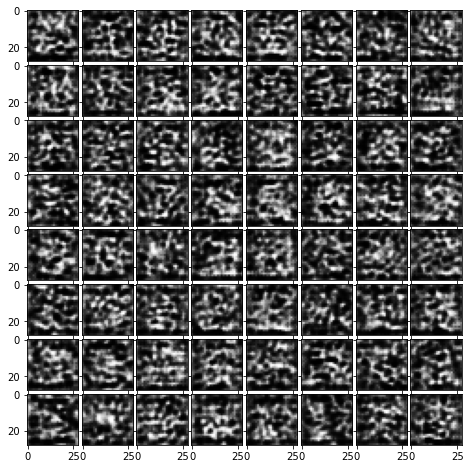

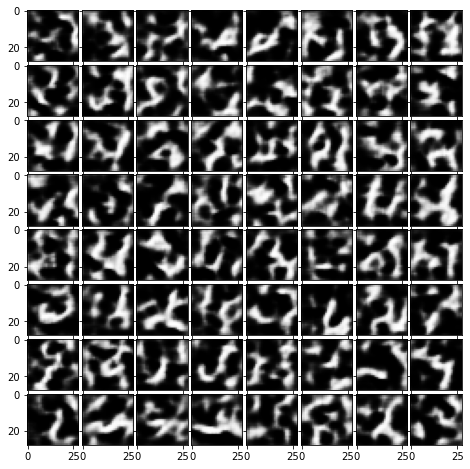

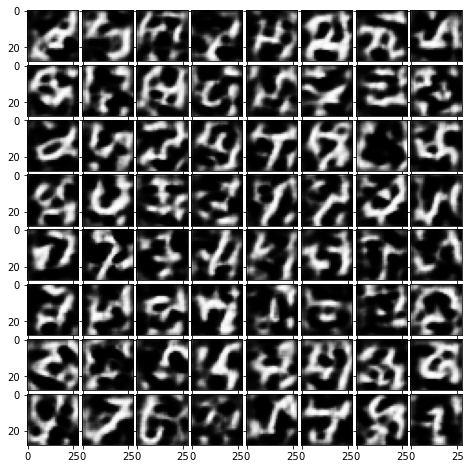

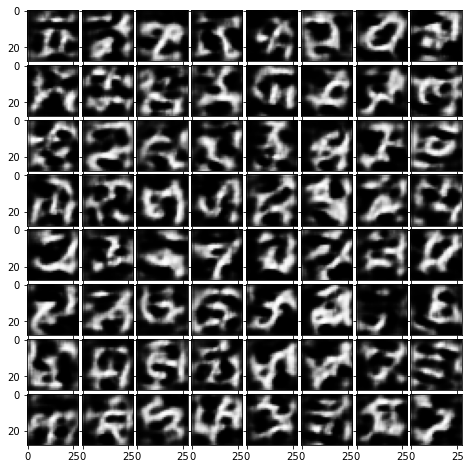

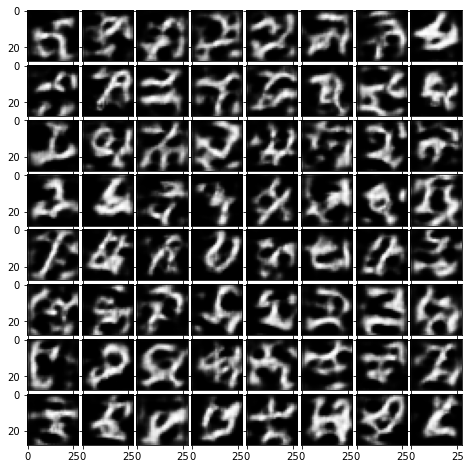

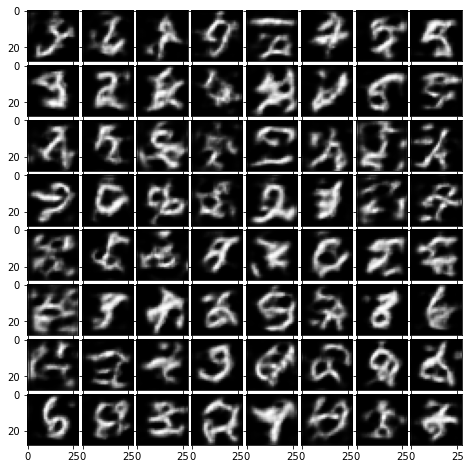

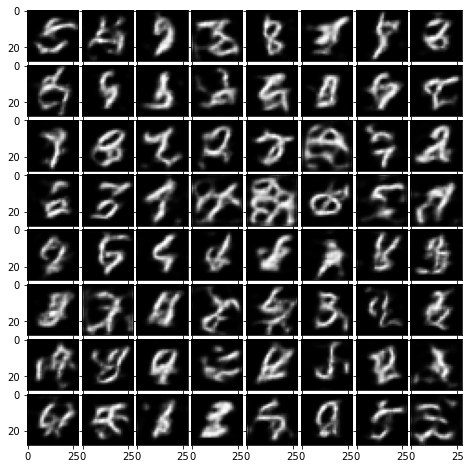

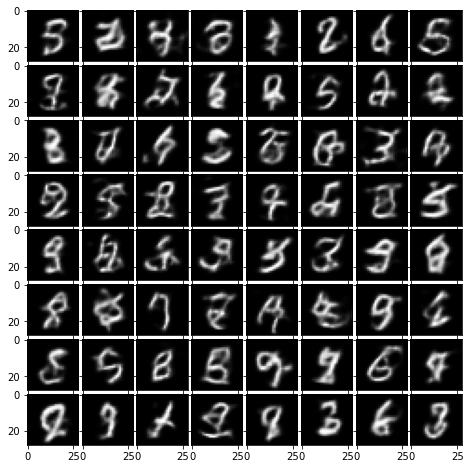

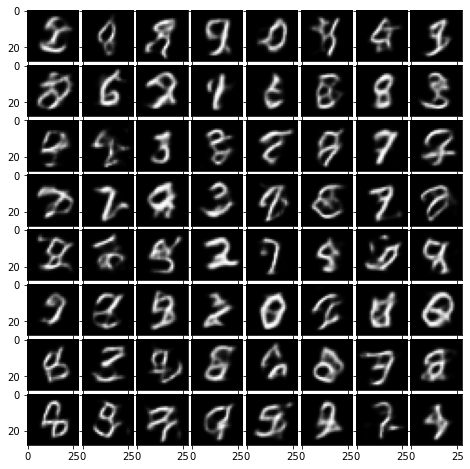

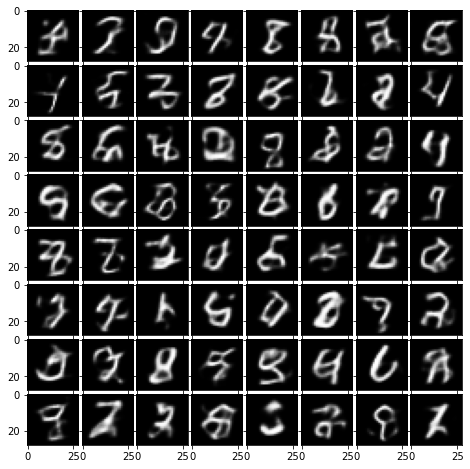

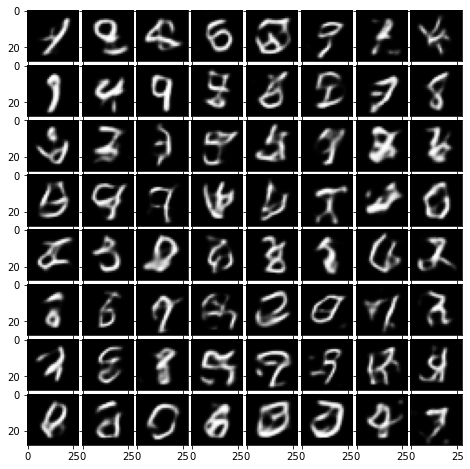

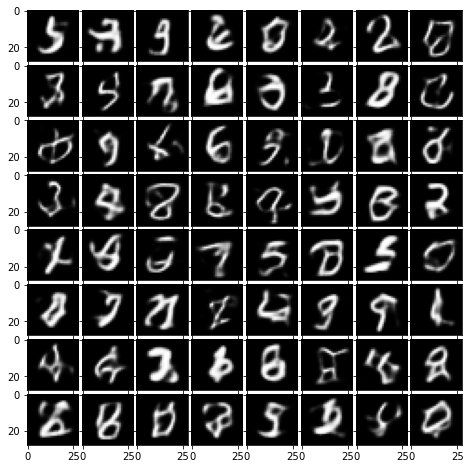

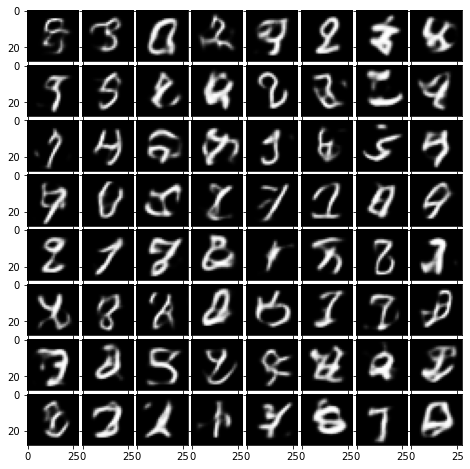

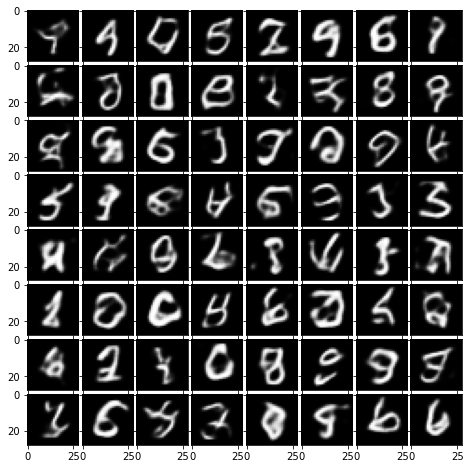

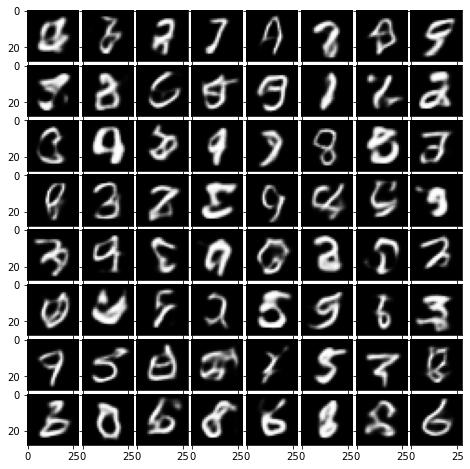

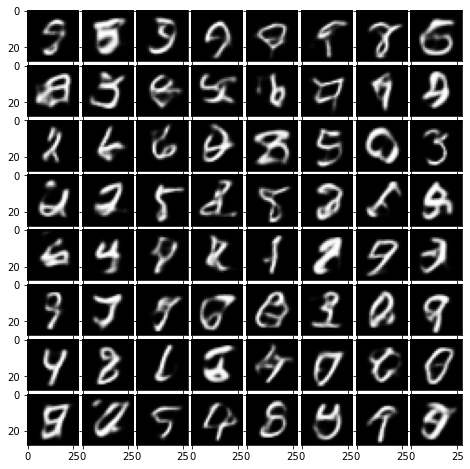

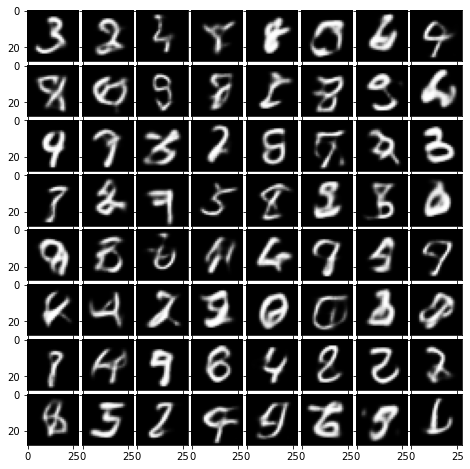

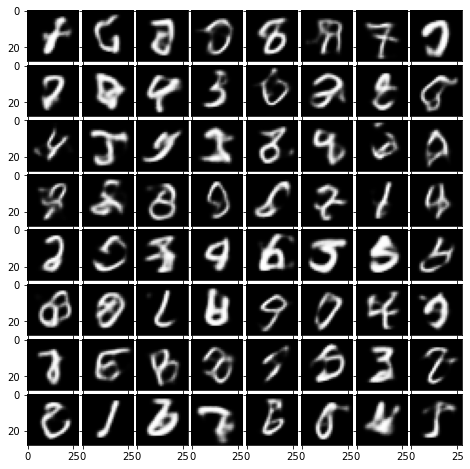

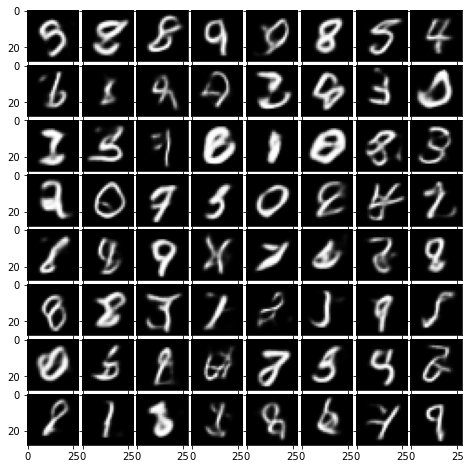

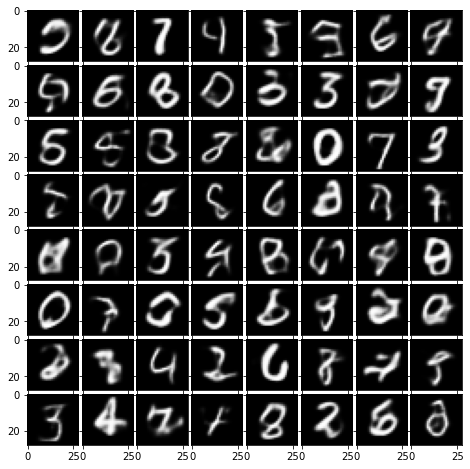

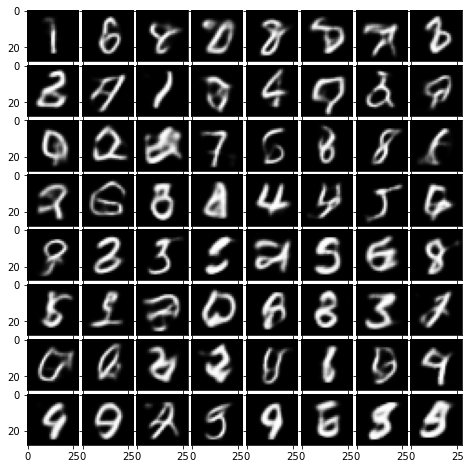

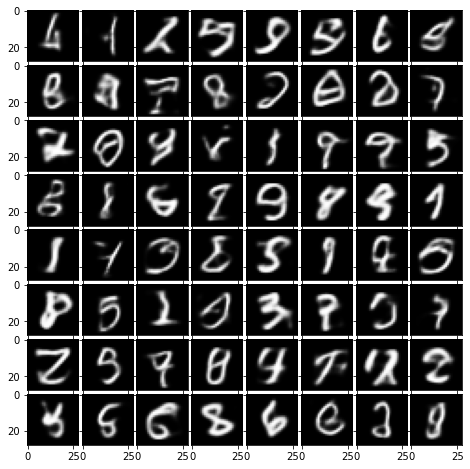

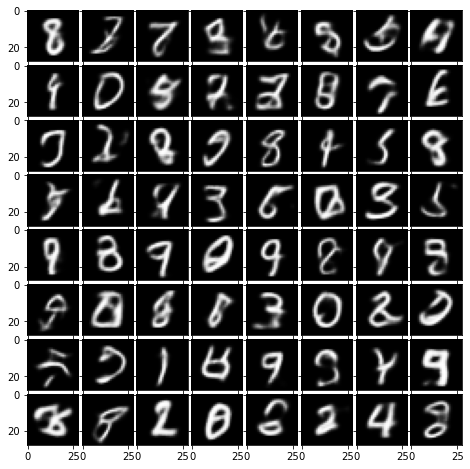

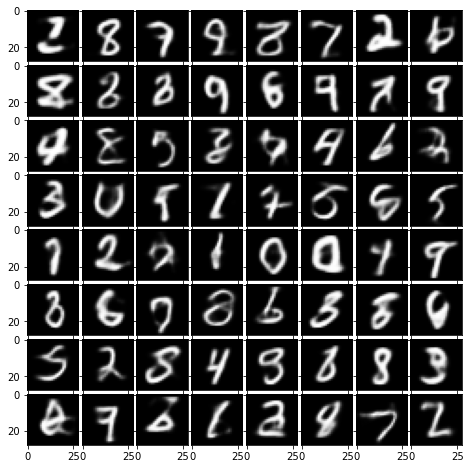

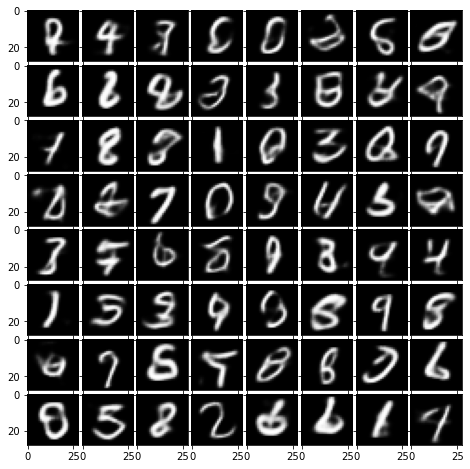

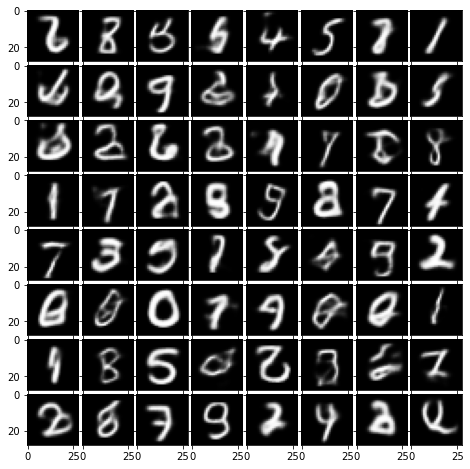

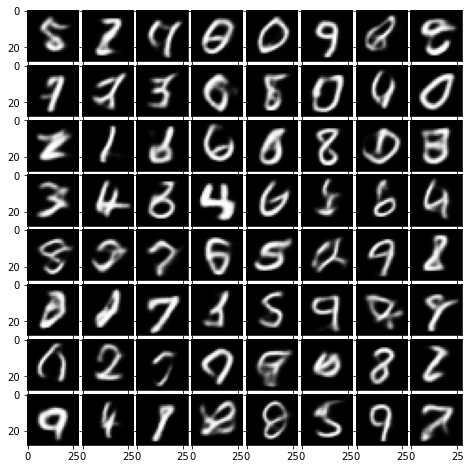

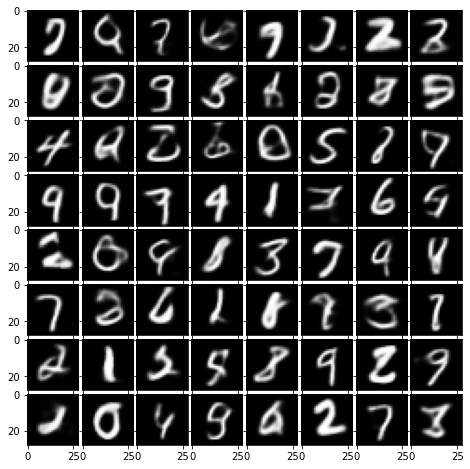

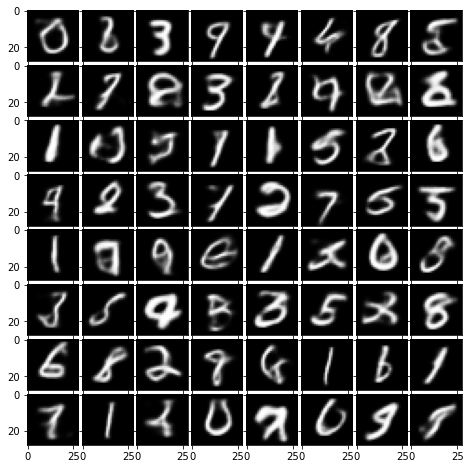

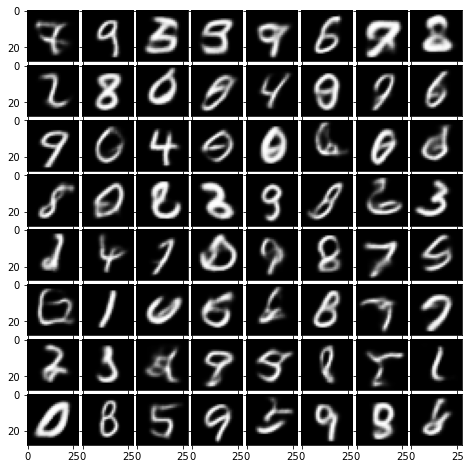

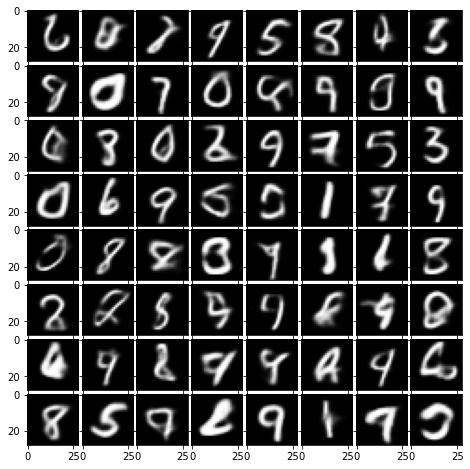

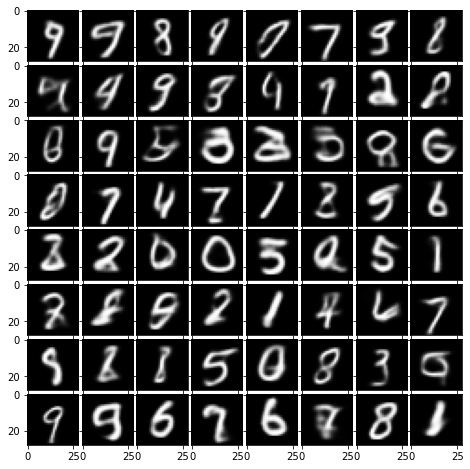

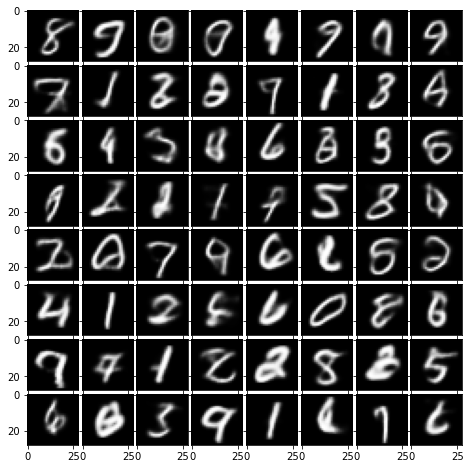

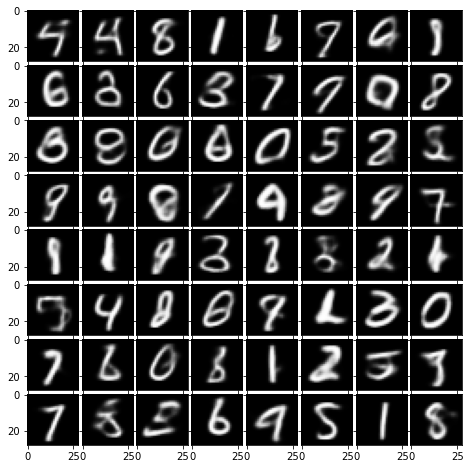

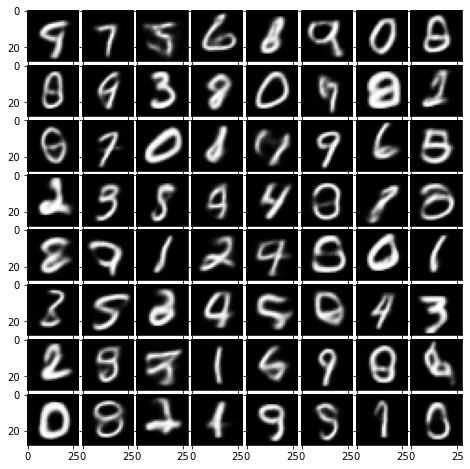

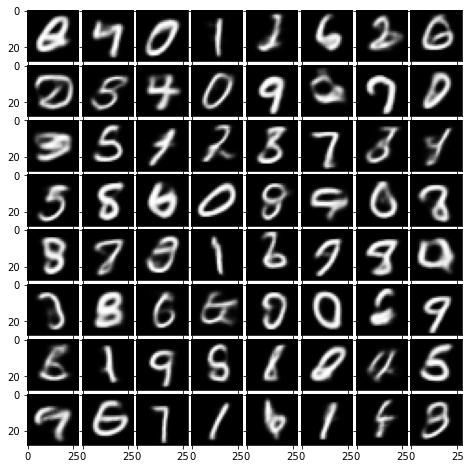

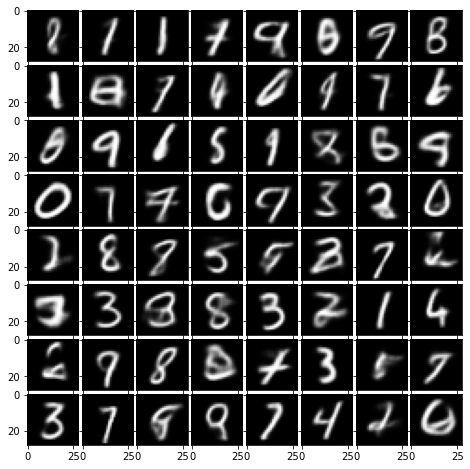

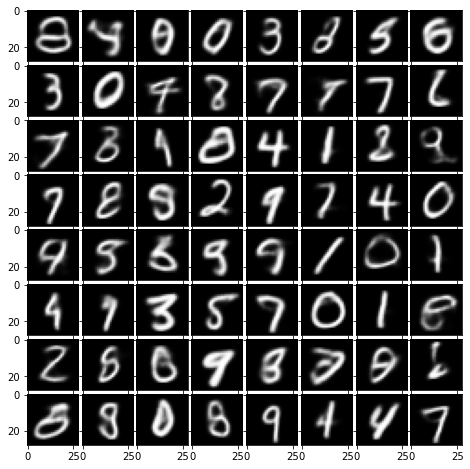

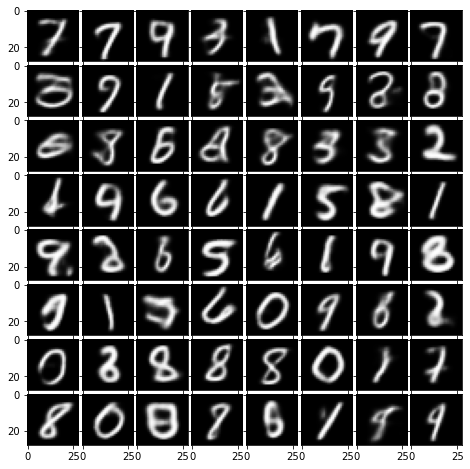

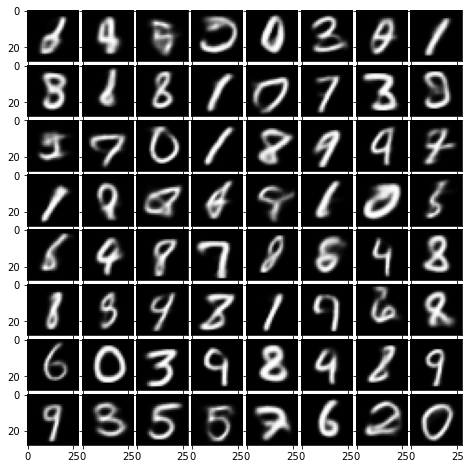

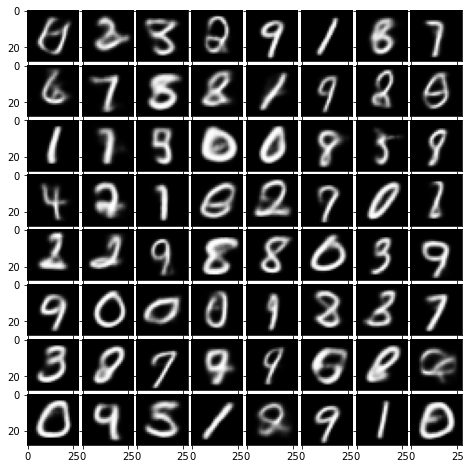

In [ ]:
for epoch in range(epochs):
    minloss = 1
    running_kl0_loss=0
    running_recons_loss=0
    running_kl1_loss=0
    num_images=0
    for i,(img,label) in enumerate(train_loader):
      img = img.to(device)
      optim.zero_grad()
      klz0,klz1,recons = model.loss(img)
      loss=recons+epoch*0.0001*klz0+epoch*0.0001*klz1
      loss.backward()
      optim.step()
      running_kl0_loss = running_kl0_loss + klz0.item()*len(img)
      running_kl1_loss = running_kl1_loss + klz1.item()*len(img)
      running_recons_loss = running_recons_loss + recons.item()*len(img)

      num_images= num_images+len(img)
    print('epoch: '+str(epoch)+' kl0_loss: '+str(running_kl0_loss/num_images)+' recons_loss: '+str(running_recons_loss/num_images)+' kl1_loss: '+str(running_kl1_loss/num_images))
    imgs = model.sample(64).cpu().detach().reshape(64,28,28)
    plt.gray()
    fig = plt.figure(figsize=(8., 8.))
    grid = ImageGrid(fig, 111, nrows_ncols=(8, 8), axes_pad=0.05)

    for ax, im in zip(grid, imgs):
        ax.imshow(im)
    plt.savefig(str(epoch)+".png")

In [ ]:
imgs = model.sample(64).cpu().detach().reshape(64,28,28)

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

<Figure size 432x288 with 0 Axes>

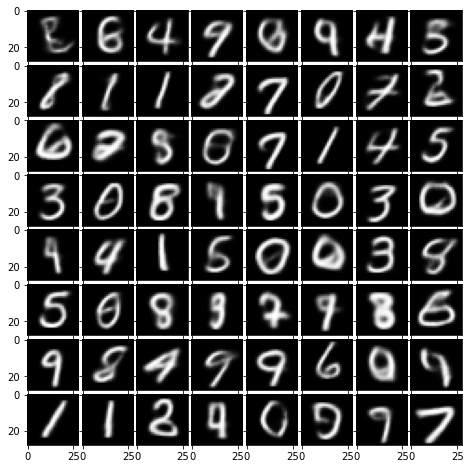

In [22]:
plt.gray()
fig = plt.figure(figsize=(8., 8.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(8, 8),  # creates 2x2 grid of axes
                 axes_pad=0.05  # pad between axes in inch.
                 )

for ax, im in zip(grid, imgs):
    # Iterating over the grid returns the Axes.
    ax.imshow(im)

plt.show()